# Taxi Demand Prediction- New York City

“If you torture the data long enough, it will confess — Ronald Coase”

## 1. Bussiness Case / Real World Probelm 

ABC company is a ride hailing company, they have large volume of subscribe users using their mobile app to get transportation services from local drivers. The mobile app for passengers and drivers will upload activities data to server for data analyst. ABC company wants to leverage AI/Machine Learning technologies to improve their business. 

**One of their key requirements is demand forecast.** They prefer to split a city into different grid, and forecast the demand in each grid at **5min, 15min and 30min** slot. If the demand goes high in future, ABC company will increase the price in that grid to slow down the demands.

ABC company would like to leverage AWS’ technology to implement the solution. However, they would like to see a proof-of-concept before the real project.

Imagine that you are a machine learning specialist from AWS, and you are required to demonstrate the potential result to ABC. Your team decided to leverage the New York City Taxi and Limousine Commission (TLC) Trip Record Data from AWS public datasets as source data (https://registry.opendata.aws/nyc-tlc-trip-records-pds/).

## 2. Data and Demo Case Study

- Data: After analysis of the huge data, you decided to use only the data after **Y2018 (Jan to June) and Manhattan as the demo area**. 
- Task: **You will design a stream of simulated input, and forecast 5min/15min/30min’s demands.**

**Note:** since the data is huge, you could just use yellow taxi part to do the work. And if you are not familiar with GIS systems, you could just use a description of grid (suggest 0.5 Mile * 0.5 Mile) to illustrate your result. 

**The key is the selection of models and algorithms, please explain why you would like to implement in that way. Moreover, you could discuss, not implement, some potential models and compare them.**

Show the "taxi_zone_map_manhattan.jpg":

<img src="../data/raw/taxi_zone_map_manhattan.jpg" alt="taxi_zone_map_manhattan" width="400"/>

## 3. Case Study Objectives & Constraints

Our objective is to predict the number of pickups as accurately as possible for each region in a 5min, 10min, 15min intervals. We will break up the whole New York City into regions.

In [1]:
!ls ../data/raw/

data_reports_monthly.csv    yellow_tripdata_2018-03.csv
shape                       yellow_tripdata_2018-04.csv
taxi+_zone_lookup.csv       yellow_tripdata_2018-05.csv
taxi_zone_map_manhattan.jpg yellow_tripdata_2018-06.csv
yellow_tripdata_2018-01.csv yellow_tripdata_2018-07.csv
yellow_tripdata_2018-02.csv


Preprocess the data into database (DB) for later analysis.

In [8]:
from sqlalchemy import create_engine
nyc_datebase_url = './nyc_database_2018a.db'
nyc_database = create_engine('sqlite:///nyc_database_2018a.db')

In [11]:
%%timeit
import pandas as pd
df_pu = pd.read_sql_query('SELECT PULocationID AS LocationID, count(*) AS PUcount \
                        FROM table_record \
                        GROUP BY PULocationID', nyc_database)

24.1 s ± 27.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
df_pu.head()

NameError: name 'df_pu' is not defined

In [3]:
nyc_data_filepaths= [ f"../data/raw/yellow_tripdata_2018-{month:0=2d}.csv" for month in range(1,7)]
nyc_data_filepaths

['../data/raw/yellow_tripdata_2018-01.csv',
 '../data/raw/yellow_tripdata_2018-02.csv',
 '../data/raw/yellow_tripdata_2018-03.csv',
 '../data/raw/yellow_tripdata_2018-04.csv',
 '../data/raw/yellow_tripdata_2018-05.csv',
 '../data/raw/yellow_tripdata_2018-06.csv']

### 3.1 Data ETL Operations
1. Load the data set and only keey the key features.
2. Select a region based on the LocationID. 
3. Select the time range to remove wrong records.

In [8]:
# 1. Load the data set and only keey the key features.
import pandas as pd  
import numpy as np
df_nyc_data = pd.read_csv(nyc_data_filepaths[0])
header_list = ["tpep_pickup_datetime", "PULocationID"] # pickup time and location only as demand / reduce RAM cost 
df_nyc_data = df_nyc_data[header_list]
df_nyc_data.shape, df_nyc_data.columns

((8759874, 2), Index(['tpep_pickup_datetime', 'PULocationID'], dtype='object'))

In [9]:
# 2. Select a region based on the LocationID.
# load the zone lookup table
nyc_zone_lookup_filepath = "../data/raw/taxi+_zone_lookup.csv"
df_zone = pd.read_csv(nyc_zone_lookup_filepath)
# df_zone.describe(include="all").T
# Get the Manhattan region location id set
df_LocationID_Manhatan = df_zone.loc[df_zone["Borough"]=="Manhattan"]
LocationID_Manhatan = df_LocationID_Manhatan["LocationID"].values
print(f"LocationID List in Manhatan {len(LocationID_Manhatan)} IDs in total :\n {LocationID_Manhatan}")
df_nyc_data_Manhatan = df_nyc_data.loc[(df_nyc_data['PULocationID'].isin(LocationID_Manhatan))]
df_nyc_data_Manhatan.shape, df_nyc_data_Manhatan.columns

LocationID List in Manhatan 69 IDs in total :
 [  4  12  13  24  41  42  43  45  48  50  68  74  75  79  87  88  90 100
 103 104 105 107 113 114 116 120 125 127 128 137 140 141 142 143 144 148
 151 152 153 158 161 162 163 164 166 170 186 194 202 209 211 224 229 230
 231 232 233 234 236 237 238 239 243 244 246 249 261 262 263]


((7965703, 2), Index(['tpep_pickup_datetime', 'PULocationID'], dtype='object'))

In [10]:
df_nyc_data_Manhatan.head()

,tpep_pickup_datetime,PULocationID
0,2018-01-01 00:21:05,41
1,2018-01-01 00:44:55,239
2,2018-01-01 00:08:26,262
3,2018-01-01 00:20:22,140
4,2018-01-01 00:09:18,246


In [11]:
df = df_nyc_data_Manhatan.copy()

df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df["year"] = df.tpep_pickup_datetime.dt.year.astype(np.uint16) 
df["month"] = df.tpep_pickup_datetime.dt.month.astype(np.uint8)
df["day"] = df.tpep_pickup_datetime.dt.day.astype(np.uint8) 
df["hour"] = df.tpep_pickup_datetime.dt.hour.astype(np.uint8) 
df["minute"] = df.tpep_pickup_datetime.dt.minute.astype(np.uint8) 
df["weekday"] = df.tpep_pickup_datetime.dt.weekday.astype(np.uint8) 
df["PULocationID"] = df["PULocationID"].astype(np.uint16)
df.head()


,tpep_pickup_datetime,PULocationID,year,month,day,hour,minute,weekday
0,2018-01-01 00:21:05,41,2018,1,1,0,21,0
1,2018-01-01 00:44:55,239,2018,1,1,0,44,0
2,2018-01-01 00:08:26,262,2018,1,1,0,8,0
3,2018-01-01 00:20:22,140,2018,1,1,0,20,0
4,2018-01-01 00:09:18,246,2018,1,1,0,9,0


In [12]:
# Select the first month
print(f"original data records number :{df.shape[0]:>10}")
df_clean = df.loc[(df["year"]==2018) & (df['month'] == 1)].copy()
print(f"afterward data records number:{df_clean.shape[0]:>10}")

original data records number :   7965703
afterward data records number:   7965396


In [13]:
df_clean.loc[:, 'demand'] = 1

In [14]:
# df_clean.head()

In [15]:
df_clean_5min = df_clean.groupby(pd.Grouper(key='tpep_pickup_datetime', freq='5min')).agg({
                                        "demand": "sum"
                                    })

In [105]:
df_demand = df_clean_5min.copy()
df_demand['month'] = df_demand.index.month
df_demand['day'] = df_demand.index.day # day of the month 
df_demand['hour'] = df_demand.index.hour 
df_demand['min'] = df_demand.index.minute
df_demand['week_of_year']= df_demand.index.isocalendar().week
df_demand['day_of_week'] = df_demand.index.dayofweek  #  Monday=0, Sunday=6.
# df_demand['day_name'] = df_demand.index.day_name().tolist()
# df_demand.info()
df_demand

/Users/caihaocui/opt/miniconda3/envs/TaxiNYC/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,demand,month,day,hour,min,week_of_year,day_of_week
tpep_pickup_datetime,,,,,,,
2018-01-01 00:00:00,360,1,1,0,0,1,0
2018-01-01 00:05:00,811,1,1,0,5,1,0
2018-01-01 00:10:00,1210,1,1,0,10,1,0
2018-01-01 00:15:00,1327,1,1,0,15,1,0
2018-01-01 00:20:00,1424,1,1,0,20,1,0
...,...,...,...,...,...,...,...
2018-01-31 23:35:00,737,1,31,23,35,5,2
2018-01-31 23:40:00,741,1,31,23,40,5,2
2018-01-31 23:45:00,714,1,31,23,45,5,2


array([[<AxesSubplot:xlabel='tpep_pickup_datetime'>],
       [<AxesSubplot:xlabel='tpep_pickup_datetime'>],
       [<AxesSubplot:xlabel='tpep_pickup_datetime'>],
       [<AxesSubplot:xlabel='tpep_pickup_datetime'>],
       [<AxesSubplot:xlabel='tpep_pickup_datetime'>],
       [<AxesSubplot:xlabel='tpep_pickup_datetime'>],
       [<AxesSubplot:xlabel='tpep_pickup_datetime'>]], dtype=object)

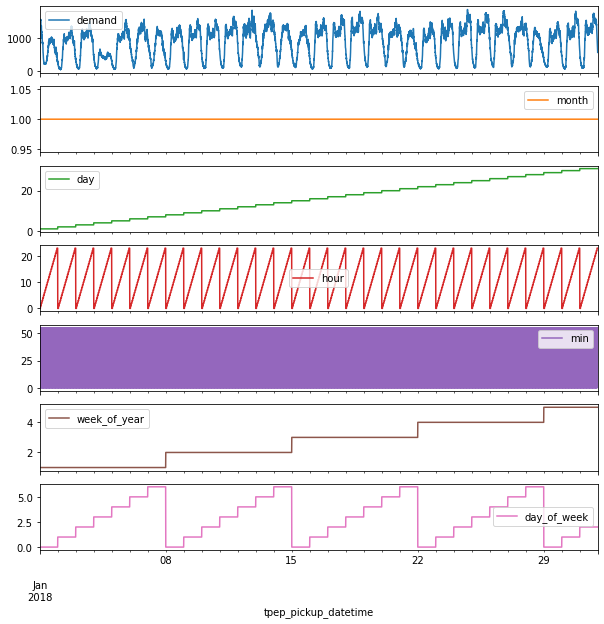

In [20]:
df_demand.plot(subplots=True, layout=(7,1), figsize=(10, 10))


## 4 Machine Learning Modelling: Demand Prediction.

**Task**: forecast 5min/15min/30min’s demands.

**Basic Assumption**:

### 4.1 Predict Taxi Demand based on the Time Only.


First, get the training data and test data ready.

In [21]:
data_type_list= {
"demand"    : np.float32,
"month"     : np.uint8,
"day"       : np.uint8,
"hour"      :np.uint8,
"min"       :np.uint8,
"week_of_year": np.uint8,
"day_of_week": np.uint8,
}

In [22]:
df_full = df_demand.astype(data_type_list).copy()
# split data into 3 parts: train, val, test 
train_df = df_full.loc[df_full["day"] <24] 
test_df =  df_full.loc[df_full["day"] >= 24]

train_df.shape,  test_df.shape

((6624, 7), (2304, 7))

In [23]:
# !pip install catboost
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension
X = train_df.drop('demand', axis=1)
y = train_df.demand

Let's split the train data into training and validation sets.

In [24]:
print(X.dtypes)
categorical_features_indices = np.where(X.dtypes != float)[0]
categorical_features_indices

month           uint8
day             uint8
hour            uint8
min             uint8
week_of_year    uint8
day_of_week     uint8
dtype: object


array([0, 1, 2, 3, 4, 5])

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)

X_test = test_df.drop('demand', axis=1)
y_test = test_df.demand

#### Model training


In [26]:
from catboost import CatBoostRegressor, Pool, cv

from sklearn.metrics import accuracy_score

In [29]:
train_pool = Pool( X_train, y_train, cat_features=categorical_features_indices )
val_pool = Pool( X_validation, y_validation, cat_features=categorical_features_indices )

model = CatBoostRegressor(
    random_seed=200,
    logging_level='Silent',
    iterations = 1000,
    learning_rate = 0.1,
    loss_function = 'MAE',
    depth=6,
    train_dir = 'model_catboot/'
)

model.fit(
    train_pool,
    eval_set = val_pool, # use t validation
    # logging_level='Verbose',  # you can uncomment this for text output
    plot=True,
    use_best_model = True,
    early_stopping_rounds = 100    
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

array([<AxesSubplot:xlabel='tpep_pickup_datetime'>,
       <AxesSubplot:xlabel='tpep_pickup_datetime'>], dtype=object)

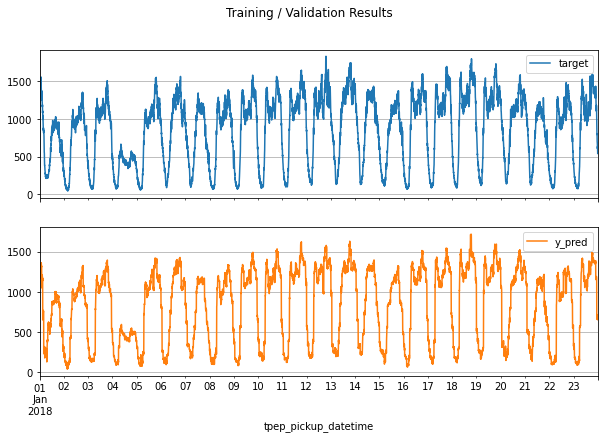

In [32]:
y_pred = model.predict(X)
df_results_train =  pd.DataFrame({'target': y.to_numpy().flatten(),'y_pred': y_pred}, index=y.index) 
df_results_train.plot(figsize=(10,6),  subplots=True, grid =True, title="Training / Validation Results")

In [36]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
print(f"MAE : {mean_absolute_error(y, y_pred)}");
print(f"MAPE: {mean_absolute_percentage_error(y, y_pred)}")

MAE : 74.42158492494266
MAPE: 0.13663205453096328


MAE : 210.8375887822429
MAPE: 0.2700480311582305


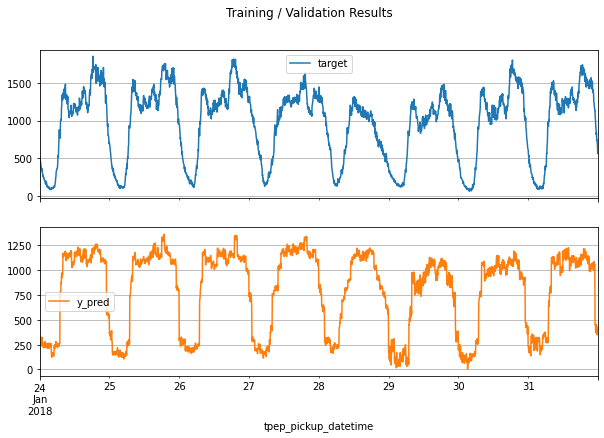

In [40]:
y_pred = model.predict(X_test)
df_results_train =  pd.DataFrame({'target': y_test.to_numpy().flatten(),'y_pred': y_pred}, index=y_test.index) 
df_results_train.plot(figsize=(10,6),  subplots=True, grid =True, title="Training / Validation Results")

print(f"MAE : {mean_absolute_error(y_test, y_pred)}");
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred)}")

,scores
features,
hour,58.460811
day,16.581746
day_of_week,14.387194
week_of_year,8.376234
min,2.194016
month,0.000000


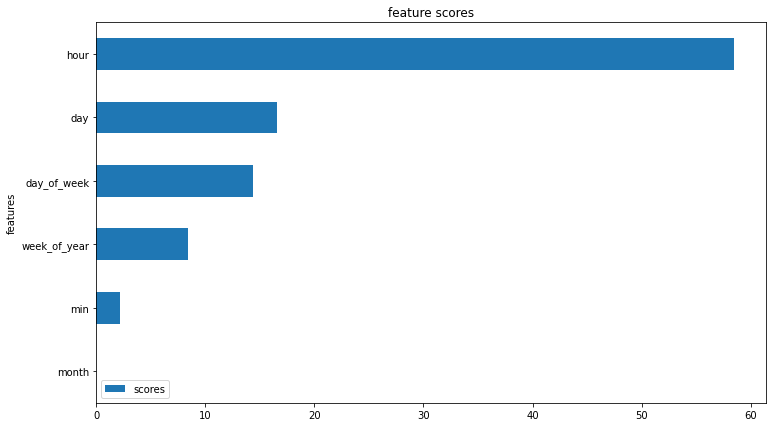

In [42]:
feature_names = X.columns
def get_feature_importances(model, feature_names):
    feature_importances = model.get_feature_importance(train_pool)
    depth = str(model.get_params()['depth'])
#     scores_name = 'scores_d' + depth
    scores_name = 'scores'
    df_feature_score = pd.DataFrame({'features': feature_names,  scores_name:feature_importances})
    df_feature_score = df_feature_score.set_index('features')
    df_sorted = df_feature_score.sort_values(by=scores_name, ascending=False)
    return df_sorted

# show scores
df_sorted = get_feature_importances(model, feature_names)
ax = df_sorted.plot.barh(y = "scores" , figsize = (12,7), title =  'feature scores')
ax.invert_yaxis()
df_sorted

For example:

In [43]:
X_test.head()

,month,day,hour,min,week_of_year,day_of_week
tpep_pickup_datetime,,,,,,
2018-01-24 00:00:00,1,24,0,0,4,2
2018-01-24 00:05:00,1,24,0,5,4,2
2018-01-24 00:10:00,1,24,0,10,4,2
2018-01-24 00:15:00,1,24,0,15,4,2
2018-01-24 00:20:00,1,24,0,20,4,2


### 4.2 Create a dummy API to get the currnet Taxi Demand

We create a few dummy input to simulate the time.

In [94]:
from datetime import datetime
from dateutil.parser import parse
 
ts= pd.date_range(datetime(2018, 2, 1, hour=12, minute=0), periods=5, freq='5min').strftime("%Y-%m-%d %H:%M:%S").tolist()
for current_time_str in ts:
    now = parse(current_time_str)
    x_in = [now.month, now.day, now.hour, now.minute, now.isocalendar()[1], now.isoweekday(), ]
    y_out = model.predict(x_in)
    print(f"{current_time_str} taxi demand is {y_out}")

2018-02-01 12:00:00 taxi demand is 750.8715655752871
2018-02-01 12:05:00 taxi demand is 691.9218701820351
2018-02-01 12:10:00 taxi demand is 711.7266908476375
2018-02-01 12:15:00 taxi demand is 755.7727900176908
2018-02-01 12:20:00 taxi demand is 743.0570951561564


We can also create a dummy API to tell the currnet demand of your localtime 

In [95]:
def current_taxi_demand(model):
    now = datetime.now()
#     print(current_time)
#     print(f"{now.year=}")
#     print(f"{now.month=}")
#     print(f"{now.day=}")
#     print(f"{now.hour=}")
#     print(f"{now.minute=}")
#     print(f"{now.second=}")
#     print(f"day of the week: {now.isoweekday()}")
#     print(f"week of the year: {now.isocalendar()[1]}")
    x_in = [now.month, now.day, now.hour, now.minute, now.isocalendar()[1], now.isoweekday(), ]
    y_out = model.predict(x_in)
    current_time = now.strftime("%Y-%m-%d %H:%M:%S")
    print(f"{current_time} taxi demand is {y_out}")
    return y_out
 
# you get the resutls based on your local time 
current_taxi_demand(model)

2021-05-19 15:07:56 taxi demand is 1192.212128128269


1192.212128128269

 ### 4.3 Model Selection with AutoGluon
 

In [96]:
from autogluon.tabular import TabularPredictor

# train_df.shape,  test_df.shape
label='demand'
save_path = 'agModels-predictDemand'  # specifies folder to store trained models
predictor = TabularPredictor(label=label, path=save_path).fit(train_df)

Beginning AutoGluon training ...
AutoGluon will save models to "agModels-predictDemand/"
AutoGluon Version:  0.2.0
Train Data Rows:    6624
Train Data Columns: 6
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1829.0, 43.0, 864.5478515625, 451.6334533691406)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    38729.12 MB
	Train Data (Original)  Memory Usage: 0.04 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureG

[1000]	train_set's rmse: 67.1701	valid_set's rmse: 81.8927
[2000]	train_set's rmse: 60.2662	valid_set's rmse: 77.4819
[3000]	train_set's rmse: 57.329	valid_set's rmse: 76.4156
[4000]	train_set's rmse: 55.6113	valid_set's rmse: 76.1734
[5000]	train_set's rmse: 54.3973	valid_set's rmse: 76.2201


	-76.1155	 = Validation root_mean_squared_error score
	4.92s	 = Training runtime
	0.08s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	train_set's rmse: 33.2357	valid_set's rmse: 43.8977
[2000]	train_set's rmse: 29.0233	valid_set's rmse: 41.7392
[3000]	train_set's rmse: 26.3878	valid_set's rmse: 41.2888
[4000]	train_set's rmse: 24.1201	valid_set's rmse: 41.0348
[5000]	train_set's rmse: 22.4067	valid_set's rmse: 41.0405


	-40.9756	 = Validation root_mean_squared_error score
	3.0s	 = Training runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-49.9257	 = Validation root_mean_squared_error score
	2.24s	 = Training runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	-39.3703	 = Validation root_mean_squared_error score
	4.38s	 = Training runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-40.4185	 = Validation root_mean_squared_error score
	0.48s	 = Training runtime
	0.03s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-116.3005	 = Validation root_mean_squared_error score
	9.8s	 = Training runtime
	0.02s	 = Validation runtime
Fitting model: XGBoost ...
	-43.4264	 = Validation root_mean_squared_error score
	1.7s	 = Training runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetMXNet ...
		Unable to import dependency mxnet. A quick tip is to install via `pip install mxnet --upgrade`, or `pip install mxnet_cu101 --upgrade`
Fitting model:

[1000]	train_set's rmse: 18.5364	valid_set's rmse: 42.5451


	-42.5129	 = Validation root_mean_squared_error score
	1.76s	 = Training runtime
	0.02s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-38.1469	 = Validation root_mean_squared_error score
	0.44s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 31.02s ...
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("agModels-predictDemand/")


In [97]:
y_test = test_df[label]  # values to predict
test_data_nolab = test_df.drop(columns=[label])  # delete label column to prove we're not cheating
test_data_nolab.head()

/Users/caihaocui/opt/miniconda3/envs/TaxiNYC/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,month,day,hour,min,week_of_year,day_of_week
tpep_pickup_datetime,,,,,,
2018-01-24 00:00:00,1,24,0,0,4,2
2018-01-24 00:05:00,1,24,0,5,4,2
2018-01-24 00:10:00,1,24,0,10,4,2
2018-01-24 00:15:00,1,24,0,15,4,2
2018-01-24 00:20:00,1,24,0,20,4,2


In [98]:
predictor = TabularPredictor.load(save_path)  # unnecessary, just demonstrates how to load previously-trained predictor from file

y_pred = predictor.predict(test_data_nolab)
print("Predictions:  \n", y_pred)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

/Users/caihaocui/opt/miniconda3/envs/TaxiNYC/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Evaluation: root_mean_squared_error on test data: -107.13946533203125
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -107.13946533203125,
    "mean_squared_error": -11478.8642578125,
    "mean_absolute_error": -82.32650756835938,
    "r2": 0.9500030294363144,
    "pearsonr": 0.9844113160941271,
    "median_absolute_error": -64.77679443359375
}


Predictions:  
 tpep_pickup_datetime
2018-01-24 00:00:00    495.689148
2018-01-24 00:05:00    482.757782
2018-01-24 00:10:00    455.905548
2018-01-24 00:15:00    416.351471
2018-01-24 00:20:00    398.055359
                          ...    
2018-01-31 23:35:00    718.455383
2018-01-31 23:40:00    691.261902
2018-01-31 23:45:00    699.533997
2018-01-31 23:50:00    686.742920
2018-01-31 23:55:00    643.185120
Freq: 5T, Name: demand, Length: 2304, dtype: float32


array([<AxesSubplot:xlabel='tpep_pickup_datetime'>,
       <AxesSubplot:xlabel='tpep_pickup_datetime'>], dtype=object)

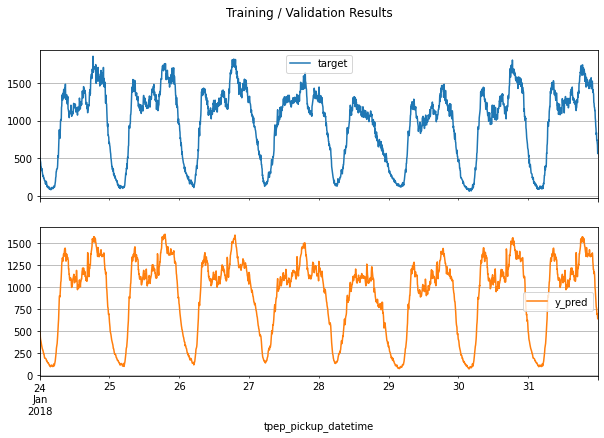

In [102]:
# y_test.shape,y_pred.shape 

df_results_train =  pd.DataFrame({'target': y_test.to_numpy().flatten(),'y_pred': y_pred}, index=y_test.index) 
df_results_train.plot(figsize=(10,6),  subplots=True, grid =True, title="Training / Validation Results")


In [103]:
print(f"MAE : {mean_absolute_error(y_test, y_pred)}");
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred)}")

MAE : 82.32650756835938
MAPE: 0.08927993476390839


/Users/caihaocui/opt/miniconda3/envs/TaxiNYC/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [104]:
predictor.leaderboard(test_df, silent=True)

/Users/caihaocui/opt/miniconda3/envs/TaxiNYC/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-107.139465,-38.146923,0.575197,0.097638,10.009314,0.003376,0.000604,0.439927,2,True,11
1,CatBoost,-108.579803,-39.370300,0.006785,0.002466,4.383008,0.006785,0.002466,4.383008,1,True,6
2,ExtraTreesMSE,-108.743675,-40.418522,0.102580,0.033750,0.483672,0.102580,0.033750,0.483672,1,True,7
3,RandomForestMSE,-110.704056,-49.925686,0.111767,0.036464,2.244194,0.111767,0.036464,2.244194,1,True,5
4,LightGBMLarge,-114.875870,-42.512947,0.087959,0.017154,1.761190,0.087959,0.017154,1.761190,1,True,10
5,LightGBM,-114.906265,-40.975574,0.231697,0.052395,3.004415,0.231697,0.052395,3.004415,1,True,4
6,XGBoost,-119.362785,-43.426353,0.230759,0.008423,1.698292,0.230759,0.008423,1.698292,1,True,9
7,LightGBMXT,-189.563812,-76.115494,0.241528,0.080174,4.920464,0.241528,0.080174,4.920464,1,True,3
8,KNeighborsDist,-239.611923,-172.922089,0.008578,0.006137,0.004024,0.008578,0.006137,0.004024,1,True,2
9,KNeighborsUnif,-242.252045,-194.809006,0.009040,0.011013,0.006908,0.009040,0.011013,0.006908,1,True,1


### 5 Trend Modelling with FB-Prophet Model

<AxesSubplot:title={'center':'Total Demand of Manhatan NYC 2018 Jan'}, xlabel='ds', ylabel='Taxi Demand'>

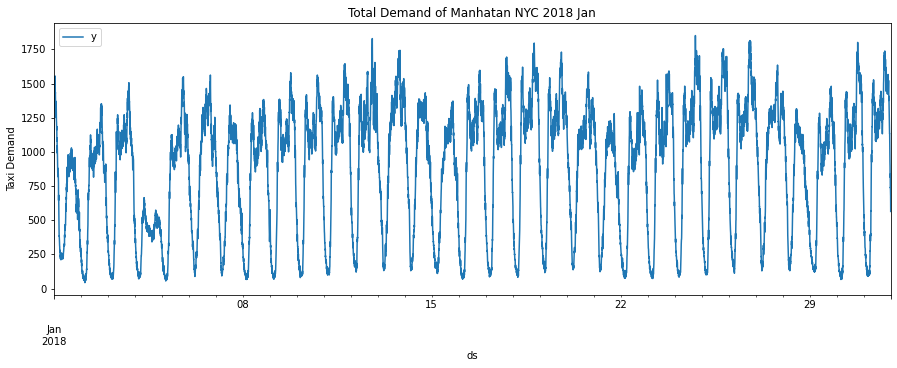

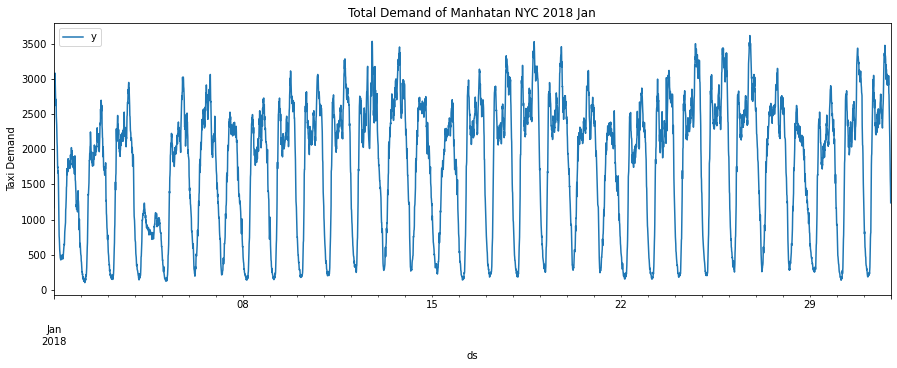

In [386]:
df_new = pd.DataFrame()

df_new["ds"] = df_clean["tpep_pickup_datetime"]
df_new["y"] = np.ones(df_clean.shape[0]).astype(np.uint64)

df_5min = df_new.groupby(pd.Grouper(key='ds', freq='5min')).agg({
                                        "y": "sum"
                                    })

df_5min.plot(
    y = "y", figsize=(15, 5), title="Total Demand of Manhatan NYC 2018 Jan", ylabel="Taxi Demand")

df_10min = df_new.groupby(pd.Grouper(key='ds', freq='10min')).agg({
                                        "y": "sum"
                                    })

df_10min.plot(
    y = "y", figsize=(15, 5), title="Total Demand of Manhatan NYC 2018 Jan", ylabel="Taxi Demand")


<AxesSubplot:title={'center':'Total Demand of Manhatan NYC 2018 Jan'}, xlabel='ds', ylabel='Taxi Demand'>

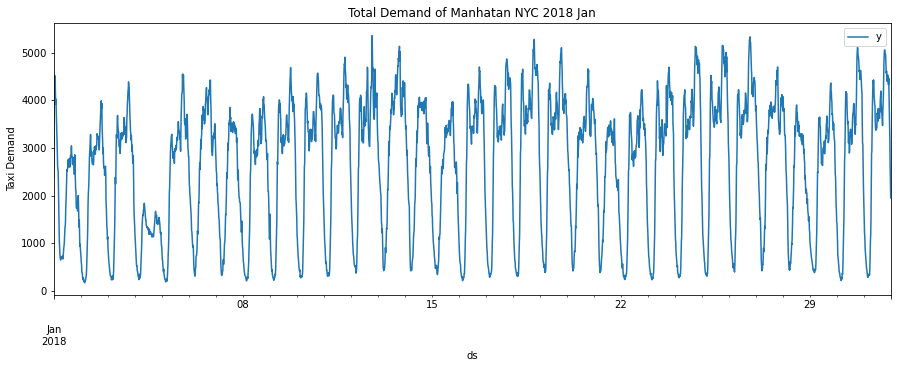

In [387]:
df_15min = df_new.groupby(pd.Grouper(key='ds', freq='15min')).agg({
                                        "y": "sum"
                                    })

df_15min.plot(
    y = "y", figsize=(15, 5), title="Total Demand of Manhatan NYC 2018 Jan", ylabel="Taxi Demand")

<AxesSubplot:title={'center':'Total Demand of Manhatan NYC 2018 Jan'}, xlabel='ds', ylabel='Taxi Demand'>

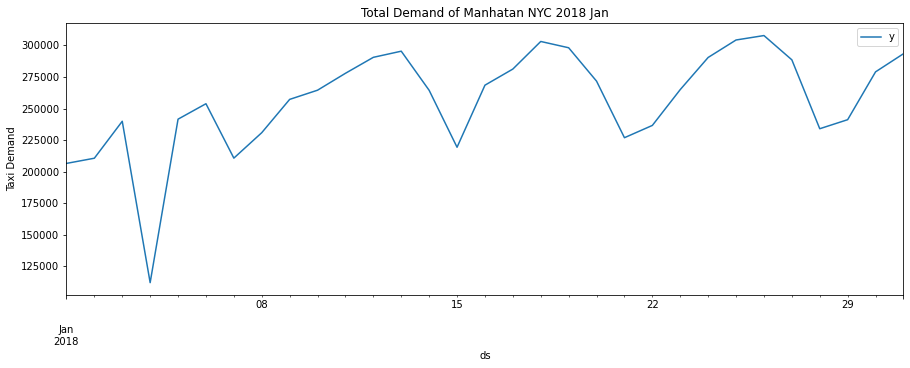

In [388]:
df_day = df_new.groupby(pd.Grouper(key='ds', freq='D')).agg({
                                        "y": "sum"
                                    })
df_day.plot(
    y = "y", figsize=(15, 5), title="Total Demand of Manhatan NYC 2018 Jan", ylabel="Taxi Demand")

In [369]:
# Python
from prophet import Prophet
df = df_15min.copy().reset_index() # put ds back to column values
m = Prophet()
m.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [370]:
future = m.make_future_dataframe(periods=100, freq='15min', ) # 60*5 mins = 300s
future.tail()

,ds
3071,2018-02-01 23:45:00
3072,2018-02-02 00:00:00
3073,2018-02-02 00:15:00
3074,2018-02-02 00:30:00
3075,2018-02-02 00:45:00


In [371]:
# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
3071,2018-02-01 23:45:00,2544.026917,1611.370986,3511.553699
3072,2018-02-02 00:00:00,2440.669914,1545.234504,3410.047402
3073,2018-02-02 00:15:00,2338.729473,1424.788587,3318.693112
3074,2018-02-02 00:30:00,2236.443430,1306.926357,3191.514220
3075,2018-02-02 00:45:00,2132.118637,1252.714654,3040.816860


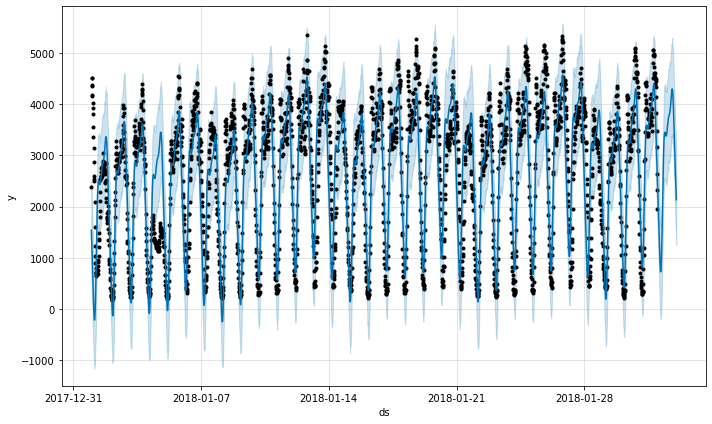

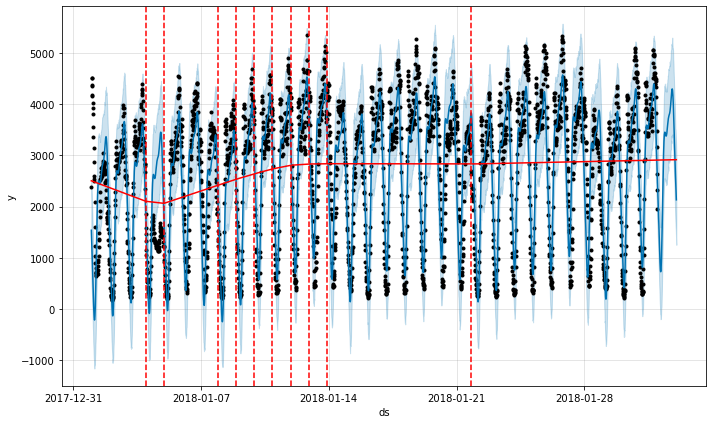

In [373]:
fig1 = m.plot(forecast)

from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


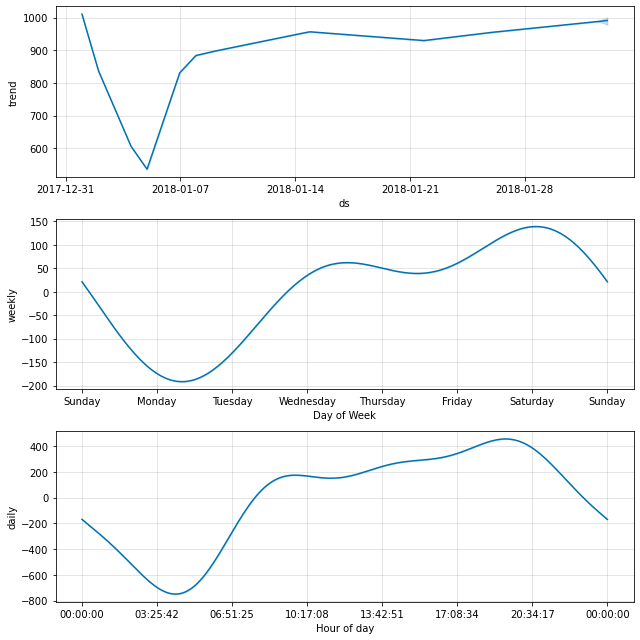

In [341]:

# Python
fig = m.plot_components(forecast)